# Computational biology and bioinformatics - <span style="color:#1CA766">INFO-F-439</span>
# Assignment 2: <span style="color:#1CA766">GOR III secondary structure prediction</span>

> ## <span style="color:#2E66A7"> Alberto Parravicini</span>

*****

# <span style="color:#2E66A7">Part 1:</span> Introduction

Proteins are for the most part defined by the aminoacid sequences that compose them. However, due to the nature of the aminoacids, proteins have more complex structures that characterize them.

Hydrogen bonds between the aminoacids in the sequence causes the proteins to assume three-dimensional structures of various kind. Being able to recognize these structures is useful to compare proteins, and to get a better insight on their properties.

Classifying correctly which portion of a protein assumes a given secondary structure isn't an easy task, but it can be seen that there are links between specific patterns of aminoacids and given secondary structures.
As an example, in $\alpha$-helices (one type of secondary structure) every third aminoacid along the sequence will tend to be hydrophobic. Also, regions richer of *alanine (A)* and *leucine (L)* will tend to form helices. (see *Gollery, Martin. "Bioinformatics: Sequence and Genome Analysis", David W. Mount. Pag. 387-388*)

***

### <span style="color:#1CA766">GOR I & II</span>:

One idea that can be exploited to predict secondary structures from aminoacid sequeces, is that the secondary structure corresponding to a certain aminoacid is influenced not only by the aminoacid itself, but also by the aminoacids that are close to it.

Given a dataset of proteins where for each aminoacid its secondary structure is known, it is possible to build a model that is able to predict secondary sequences, by using the idea above.

This is the core idea behind the **GOR I** and **GOR II** algorithms.

For a given position $j$, it will be predicted the secondary structure $S_j$ that has the highest value of *information*, as function of the aminoacid sequence.
Assuming that our secondary structures are in the set $S = \{\alpha$-helices (**H**), $\beta$-sheets (**B**), and coils (**C**)$\}$, the one that will be chosen is $$S_j = \arg\max_{S}{I(\Delta S_j;\ a_1, \ldots, a_n)}$$ where $a_1, \ldots, a_n$ is the aminoacid sequence, and $S_j$ is picked among the secondary structures in S.

The previous computation is approximated by **GOR** by considering a window of size $17$ around position $j$, which gives the formula $$S_j = \arg\max_{S}{I(\Delta S_j;\ a_1, \ldots, a_n)} \approx \arg\max_{S}{\sum_{m = -8}^{m = 8}{I(\Delta S_j;\ a_{j+m})}}$$ 

In the previous formulation, $I(\Delta S_j;\ a_{j+m})$ is a measure of *self-information*, and is given by
$$I(\Delta S_j;\ a_{j+m}) = log(\frac{c_{S_j,\ a_{j+m}}}{c_{\neg S_j,\ a_{j+m}}}) + log(\frac{c_{\neg S}}{c_{S}})$$

where $c$ refers to the count of the occurrences (in a given dataset) of what is specified in the subscript; for instance, $c_{\neg S}$ is the number of aminoacids with a secondary structure different from $S$.

In Python, we can compute $c_{S_j,\ a_{j+m}}$ and $I(\Delta S_j;\ a_{j+m})$ in the following way:

In [1]:
def count_residues_gor_1(s_list, a_list, s_j, a_jm, lag):
    """
    Count the number of times that structure "s_j" appears,
    and residue "a_jm" is at distance "lag" from them.
    :param s_list: a list of secondary structures; pandas Series.
    :param a_list: a list of aminoacids; pandas Series.
    :param s_j: a secondary structure name.
    :param a_jm: an aminoacid name.
    :param lag: distance from a_j at which a_jm is searched.
    :return: int
    """
    n = len(s_list)
    count = 0
    for i in range(max(0, -lag), min(n, n - lag)):
        if s_list.iloc[i] == s_j and a_list.iloc[i + lag] == a_jm:
            count += 1
    return count

In [2]:
def info_value_gor_1(s_list, a_list, s_j, a_jm, lag, a_occ):
    """
    Compute the information value associated to a secondary structure s_j, in position j,
    and to an aminoacid a_jm, at distance m from s_j.
    :param s_list: a list of secondary structures; pandas Series.
    :param a_list: a list of aminoacids; pandas Series.
    :param s_j: a secondary structure name.
    :param a_jm: an aminoacid name.
    :param lag: distance from a_j at which a_jm is searched.
    :param a_occ: number of occurrencies of each aminoacid; pandas Series.
    :return: double
    """
    num_1 = count_residues_gor_1(s_list, a_list, s_j, a_jm, lag)
    den_1 = a_occ[a_jm] - num_1
    den_2 = s_occ[s_j]
    num_2 = len(s_list) - den_2
    return np.log(num_1 * num_2) - np.log(den_1 * den_2)

***

### <span style="color:#1CA766">GOR III</span>:

It is possible to improve the accuracy of **GOR I & II** by considering not only the occurrencies of aminoacids close to the position where we want to predict the secondary structure, but also their occurrencies relatively to the aminoacid found at that given position.

This means that the information value of a secondary structure $S_j$ will be approximated as 

$$S_j = \arg\max_{S}{I(\Delta S_j;\ a_1, \ldots, a_n)} \approx \arg\max_{S}{\sum_{m = -8}^{m = 8}{I(\Delta S_j;\ a_{j+m}\ |\ a_j)}} = \ldots$$ 
$$\ldots = I(\Delta S_j;\ a_j) + \sum_{m = -8,\ m \neq 0}^{m = 8}{I(\Delta S_j;\ a_{j+m}\ |\ a_j)}$$

where it holds $$I(\Delta S_j;\ a_{j+m}\ |\ a_j) = log(\frac{c_{S_j,\ a_{j+m},\ a_j}}{c_{\neg S_j,\ a_{j+m},\ a_j}}) + log(\frac{c_{\neg S_j,\ a_j}}{c_{S_j,\ a_j}})$$

In Python, we can compute $c_{S_j,\ a_{j+m},\ a_j}$ and $I(\Delta S_j;\ a_{j+m}\ |\ a_j)$ as:

In [3]:
def count_residues_gor_3(s_list, a_list, s_j, a_j, a_jm, lag):
    """
    Count the number of times that structure "s_j" appears together with residue "a_j",
    and residue "a_jm" is at distance "lag" from them.
    :param s_list: a list of secondary structures; pandas Series.
    :param a_list: a list of aminoacids; pandas Series.
    :param s_j: a secondary structure name
    :param a_j: an aminoacid name
    :param a_jm: an aminoacid name
    :param lag: distance from a_j at which a_jm is searched
    :return: int
    """
    n = len(s_list)
    count = 0
    for i in range(max(0, -lag), min(n, n - lag)):
        if s_list.iat[i] == s_j and a_list.iat[i] == a_j and a_list.iat[i + lag] == a_jm:
            count += 1
    return count

In [4]:
def info_value_gor_3(s_list, a_list, s_j, a_j, a_jm, lag, a_occ):
    """
    Compute the information value associated to an aminoacid a_j in position j,
    with secondary structure s_j, in position j,
    and to an aminoacid a_jm, at distance m from s_j.
    :param s_list: a list of secondary structures; pandas Series.
    :param a_list: a list of aminoacids; pandas Series.
    :param s_j: a secondary structure name
    :param a_j: an aminoacid name
    :param a_jm: an aminoacid name
    :param lag: distance from a_j at which a_jm is searched
    :param a_occ: number of occurrencies of each aminoacid
    :return: double
    """
    # Num of times s_j appears with a_j, and a_jm is lag position distant.
    num_1 = count_residues_gor_3(s_list, a_list, s_j, a_j, a_jm, lag)
    # Num of times a_j appears with a secondary structure different from s_j,
    # and a_jm is lag position distant.
    den_1 = count_aminoacid_lag(a_list, a_j, a_jm, lag) - num_1
    
    # Number of times aminoacid a_j appears together with structure s_j.                        
    den_2 = count_residues_gor_3(s_list, a_list, s_j, a_j, a_j, 0)                          
    # Number of times aminoacid a_j appears with a different structure from s_j.
    num_2 = a_occ[a_j] - den_2
                 
    info = np.log(num_1) - np.log(den_1) + np.log(num_2) - np.log(den_2)   
    return info     

*****

# <span style="color:#2E66A7">Part 2:</span> Data pre-processing

To compute the information values for each combination of aminoacids and secondary structures, it is necessary to have a large dataset of proteins with known secondary structures. We are provided with a set of 498 proteins, where the secondary structures have been determined by **DSSP** and **STRIDE**.

Before being able to apply **GOR III**, it is required to preprocess the dataset, clean the inconsistencies that might be present, and store the aminoacid sequences in an appropriate way.

It can be noted that there are a few rows with aminoacids that are not part of the usual 20. As the number of these rows is very limited compared to the total, we can just remove them entirely, and this won't affect the overall results of the algorithm.

IMPORTANT NOTE: plot visualization requires the **bokeh** library.  
It can be installed with:

    pip install bokeh
    
or:

    conda install bokeh

In [5]:
#%% IMPORT DATA

import pandas as pd
import numpy as np
import timeit
import pickle

aminoacid_list = "arndceqghilkmfpstwyv"

# Dictionary that maps aminoacid codes to single letters.
aminoacid_codes = {"ala":  "a",
                   "arg":  "r",
                   "asn":  "n",
                   "asp":  "d",
                   "cys":  "c",
                   "gln":  "q",
                   "glu":  "e",
                   "gly":  "g",
                   "his":  "h",
                   "ile":  "i",
                   "leu":  "l",
                   "lys":  "k",
                   "met":  "m",
                   "phe":  "f",
                   "pro":  "p",
                   "ser":  "s",
                   "thr":  "t",
                   "trp":  "w",
                   "tyr":  "y",
                   "val":  "v"}

In [6]:
# BOKEH is required to visualize the plots!
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import bokeh.charts as ch
output_notebook()

Loading BokehJS ...

In [7]:
def preprocess_input(file_name, aminoacid_codes):
    """
    Load and preprocess a file containing protein sequences.
    The output will be a DataFrame ready to be used by GOR.
    :param file_name: string, name of the file to be opened.
    :param aminoacid_codes: dictionary that maps aminoacid codes to single letters.
    :return: DataFrame
    """
    # Load the data
    input_data = pd.read_csv(file_name,
                         header=None, sep="\t",
                         names=["PDB_code", "PDB_chain_code", "PDB_seq_code", "residue_name", "secondary_structure"])

    # CLEAN DATA - AMINOACIDS

    # There are some values that are weird, like "a", "b", ...
    # Some of those can be interpreted as correct aminoacids.

    # Remove rows with "X", "b", "UNK"
    # First, remove any leading spaces, then remove "X", "b", "UNK"
    input_data["residue_name"] = input_data["residue_name"].str.strip()
    input_data = input_data.drop(input_data[input_data["residue_name"].isin(["X", "b", "UNK"])].index).reset_index(drop=True)


    # Add a column for the aminoacids, while preserving the original one
    input_data["a"] = input_data["residue_name"]
    input_data["a"] = input_data["a"].str.lower()


    # replace the codes with something shorter
    input_data["a"] = input_data["a"].map(lambda x: aminoacid_codes[x] if x in aminoacid_codes else x)

    # Create a new column
    input_data["s"] = input_data["secondary_structure"]
    input_data["s"] = input_data["s"].str.lower()
    # Replace "other" with "coil"
    input_data.loc[input_data["s"] == "other", "s"] = "coil"
    # Shorten values
    input_data["s"] = input_data["s"].str[0]
    
    # Add a composite key to the dataset.
    # Append the PDB chain code to the PDB code, to obtain unique protein identifier.
    input_data["PDB_code_and_chain"] = input_data.PDB_code + "_" + input_data.PDB_chain_code

    return input_data


We can load and work on the *STRIDE* dataset. The *DSSP* dataset is similar, and will be compared to *STRIDE* later in the report. 

In [8]:
    # Type of the data to read ("stride", "dssp")
    data_type = "stride"
    # File name
    file_name = "../data/" + data_type + "_info.txt"
    # Read the data
    input_data = preprocess_input(file_name, aminoacid_codes)

    # Look at the aminoacid values
    aminoacids = set(input_data.residue_name)
    print(aminoacids)
    # Same stuff with the secondary structures
    secondary_structures = set(input_data.secondary_structure)
    print(secondary_structures)

{'GLU', 'ASP', 'HIS', 'TRP', 'THR', 'ILE', 'ALA', 'LYS', 'ASN', 'SER', 'MET', 'TYR', 'GLN', 'PRO', 'CYS', 'GLY', 'PHE', 'VAL', 'ARG', 'LEU'}
{'Helix', 'Beta', 'Other'}


In [9]:
input_data.iloc[0:5, ]

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,secondary_structure,a,s,PDB_code_and_chain
0,1w0n,A,12,ILE,Other,i,c,1w0n_A
1,1w0n,A,13,THR,Beta,t,b,1w0n_A
2,1w0n,A,14,LYS,Beta,k,b,1w0n_A
3,1w0n,A,15,VAL,Beta,v,b,1w0n_A
4,1w0n,A,16,GLU,Beta,e,b,1w0n_A


**PDB_code** and **PDB_chain_code** work as identifier of the row. The column **a** and **s** are just shortened versions of the aminoacid codes and of the secondary structure codes.

We can also compute some other values, that will be useful later. These values can be stored for future re-use. Note that they have already been stored, so there is no need to do it again.

In [10]:
# Number of residues
n_res = len(input_data.index)

# Compute the number of occurrencies of each aminoacid
a_occ = input_data["a"].value_counts()

# Compute the number of occurrencies of each secondary structure
s_occ = input_data["s"].value_counts()
   
 
# # UNCOMMENT IF NECESSARY
# # Save data
# a_occ_file_name = "a_occ_"+ data_type + ".p"
# # Open the file for writing.
# file_object = open(a_occ_file_name.encode('utf-8').strip(), 'wb')
# # Save data
# pickle.dump(a_occ, file_object)
# file_object.close()

# s_occ_file_name = "s_occ_"+ data_type + ".p"
# # Open the file for writing.
# file_object = open(s_occ_file_name.encode('utf-8').strip(), 'wb')
# # Save data
# pickle.dump(s_occ, file_object)
# file_object.close()

In [11]:
n_res

71073

In [12]:
a_occ

l    6449
a    5963
g    5119
v    4960
e    4816
d    4244
k    4213
s    4148
i    4034
t    3937
r    3665
p    3181
n    3053
f    2890
q    2849
y    2467
h    1715
m    1260
c    1103
w    1007
Name: a, dtype: int64

In [13]:
p = ch.Bar(pd.DataFrame({'label':a_occ.index, 'val':a_occ.values}), values="val", title="Aminoacid occurrencies", plot_width=800, legend=None, label=ch.attributes.CatAttr(columns="label", sort=False))
show(p)

*Leucine (L), Alanine (A), Glycine (G)* are the most common aminoacids! 

In [14]:
data_type_2 = "dssp"
# File name
file_name_2 = "../data/" + data_type_2 + "_info.txt"
# Read the data
input_data_2 = preprocess_input(file_name_2, aminoacid_codes)

s_occ_2 = input_data_2["s"].value_counts()

print(s_occ)
print(s_occ_2)

input_data["type"] = data_type
input_data_2["type"] = data_type_2
input_data_tot = pd.concat([input_data, input_data_2])

c    29170
h    25755
b    16148
Name: s, dtype: int64
c    30211
h    24936
b    15800
Name: s, dtype: int64


In [15]:
p = ch.Bar(input_data_tot, agg='sum', group='type', title="Secondary structure occurrencies per file", label="s")
show(p)

*Coils (C)* are the most common secondary structures in our dataset! 
Also, in **DSSP** there are sightly more *coils*.

In [16]:
p = ch.Bar(input_data, label='a', agg='sum', group='s',
        title="Number of aminoacids, grouped by secondary structure, STRIDE", legend='top_right', width=800)
show(p)

We can see how *Glycine (G)* has almost always a *coil* structure, and *leucine (L)* is often an $\alpha$-helix.

*****

# <span style="color:#2E66A7">Part 3:</span> GOR III

Now, to compute the information values of **GOR III** it is required to add a few more functions.

The first will compute a matrix that stores, for each aminoacid, the occurrences of each secondary structure.  
The second will build a dictionary where each key corresponds to a secondary structure, and each value is a tensor (technically, a pandas.Panel) that stores the number of times where an aminoacid $a_j$ appears with secondary structure $S_j$,
and another aminoacid $a_{j+m}$ appears at a distance $m$ from them, with $m$ in $[-8, 8]$.

It is necessary to precompute these matrices as counting from scratch the occurrencies, for each prediction, could be very inefficient.

In [17]:
def build_sj_aj_matrix(s_list, a_list):
    """
    Count the number of times that each aminoacid a_j has secondary structure s_j.
    :param s_list: a list of secondary structures; pandas Series.
    :param a_list: a list of aminoacids; pandas Series.
    :return: pandas.DataFrame
    """
    # Set of all secondary structures.
    sec_structure_set = ["h", "b", "c"]
    # Set of all aminoacids.
    aminoacid_set = set(a_list)
    # Occurrency matrix.
    sj_aj_matrix = pd.DataFrame(0, index=sec_structure_set, columns=aminoacid_set, dtype=int)
    # Zip together the lists of secondary structures and aminoacids, it makes counting easier.
    s_a_list = [list(x) for x in zip(s_list,a_list)]
    # Count the occurrencies.
    for s in sec_structure_set:
        for a in aminoacid_set:
            sj_aj_matrix.at[s, a] = s_a_list.count([s, a])

    return sj_aj_matrix

In [18]:
start_time = timeit.default_timer()
sj_aj_matrix = build_sj_aj_matrix(input_data.s, input_data.a)
end_time = timeit.default_timer()
print("! -> EXECUTION TIME OF build_sj_aj_matrix:", (end_time - start_time), "\n")

! -> EXECUTION TIME OF build_sj_aj_matrix: 0.38105379238818776 



In [19]:
sj_aj_matrix

,p,s,y,e,d,w,f,m,n,r,h,c,t,g,l,k,i,q,a,v
h,467,1204,850,2348,1338,377,1012,547,916,1586,570,305,1089,850,3071,1795,1468,1369,2992,1601
b,335,771,827,773,530,294,938,282,447,742,400,301,1135,804,1573,809,1572,493,1007,2115
c,2379,2173,790,1695,2376,336,940,431,1690,1337,745,497,1713,3465,1805,1609,994,987,1964,1244


These values can be stored for future re-use. Note that they have already been stored, so there is no need to do it again.

In [20]:
# # UNCOMMENT IF NECESSARY

# # Save data
# mat_file_name = "sj_aj_matrix_"+ data_type + ".p"

# # Open the file for writing.
# file_object = open(mat_file_name.encode('utf-8').strip(), 'wb')
# # Save data
# pickle.dump(sj_aj_matrix, file_object)

# file_object.close()

In [55]:
def build_sj_aj_ajm(input_data, print_details=True):
    """
    Count the times where aminoacid a_j appears with secondary structure s_j,
    and aminoacid a_jm appears at a distance m from them, with m in [-8, 8].
    """
    # Set of all proteins.
    protein_set = list(set(input_data.PDB_code_and_chain))
    # Set of all secondary structures.
    sec_structure_set = ["h", "b", "c"]
    # Set of all aminoacids.
    aminoacid_set = list(set(input_data.a))
    # Build a dictionary where the keys are the secondary structures, and the values are 3D tensors
    # with index a_j, a_jm, m.
    sj_aj_ajm_dict = {s: pd.Panel(data=0, items=aminoacid_set, major_axis=aminoacid_set, minor_axis=np.arange(-8, 9), dtype=int) for s in sec_structure_set}

    # The counting must be done separately for each protein,
    # otherwise the aminoacids at the end of one protein would be counted
    # as part of the next one!
    for i_p, p in enumerate(protein_set):
        s_list = input_data.loc[input_data['PDB_code_and_chain'] == p].s
        a_list = input_data.loc[input_data['PDB_code_and_chain'] == p].a
        n = len(s_list)
        for i_aj, a_j in enumerate(aminoacid_set):
            for i_ajm, a_jm in enumerate(aminoacid_set):
                for i_m, m in enumerate(np.arange(-8, 9)):
                    if print_details:
                        print(p, a_j, a_jm, m, "-------", i_p / len(protein_set), i_aj / 20, i_ajm / 20)

                    for i in range(max(0, -m), min(n, n - m)):
                        if a_list.iat[i] == a_j and a_list.iat[i + m] == a_jm:
                            # Increment the count of the right dictionary.
                            sj_aj_ajm_dict[s_list.iat[i]].iat[i_aj, i_ajm, i_m] += 1

    return sj_aj_ajm_dict

In [56]:
# Count the times where aminoacid a_j appears with secondary structure s_j,
# and aminoacid a_jm appears at a distance m from them, with m in [-8, 8].
#   WARNING: this can take a bit of time, usually about 20-30 minutes;
#            do it at your own risk!
start_time = timeit.default_timer()
##########################
# UNCOMMENT IF NEEDED ####
##########################
# sj_aj_ajm_dict = build_sj_aj_ajm(input_data)

end_time = timeit.default_timer()
print("! -> EXECUTION TIME OF build_sj_aj_ajm:", (end_time - start_time), "\n")

1g6u_A p p -8 ------- 0.0 0.0 0.0
1g6u_A p p -7 ------- 0.0 0.0 0.0
1g6u_A p p -6 ------- 0.0 0.0 0.0
1g6u_A p p -5 ------- 0.0 0.0 0.0
1g6u_A p p -4 ------- 0.0 0.0 0.0
1g6u_A p p -3 ------- 0.0 0.0 0.0
1g6u_A p p -2 ------- 0.0 0.0 0.0
1g6u_A p p -1 ------- 0.0 0.0 0.0
1g6u_A p p 0 ------- 0.0 0.0 0.0
1g6u_A p p 1 ------- 0.0 0.0 0.0
1g6u_A p p 2 ------- 0.0 0.0 0.0
1g6u_A p p 3 ------- 0.0 0.0 0.0
1g6u_A p p 4 ------- 0.0 0.0 0.0
1g6u_A p p 5 ------- 0.0 0.0 0.0
1g6u_A p p 6 ------- 0.0 0.0 0.0
1g6u_A p p 7 ------- 0.0 0.0 0.0
1g6u_A p p 8 ------- 0.0 0.0 0.0
1g6u_A p s -8 ------- 0.0 0.0 0.05
1g6u_A p s -7 ------- 0.0 0.0 0.05
1g6u_A p s -6 ------- 0.0 0.0 0.05
1g6u_A p s -5 ------- 0.0 0.0 0.05
1g6u_A p s -4 ------- 0.0 0.0 0.05
1g6u_A p s -3 ------- 0.0 0.0 0.05
1g6u_A p s -2 ------- 0.0 0.0 0.05
1g6u_A p s -1 ------- 0.0 0.0 0.05
1g6u_A p s 0 ------- 0.0 0.0 0.05
1g6u_A p s 1 ------- 0.0 0.0 0.05
1g6u_A p s 2 ------- 0.0 0.0 0.05
1g6u_A p s 3 ------- 0.0 0.0 0.05
1g6u_A p s 4 --

KeyboardInterrupt: 

As the computation of the dictionary can take a fair bit of time, it is a good idea to store the result, and load it when needed.

Note: comment/uncomment the following lines depending on your needs! The trained models should be already available, so there is no need to run the code.

In [23]:
# Save data
dict_file_name = "sj_aj_ajm_dict_"+ data_type + ".p"

# # Open the file for writing.
# file_object = open(dict_file_name.encode('utf-8').strip(), 'wb')

# # Save data
# pickle.dump(sj_aj_ajm_dict, file_object)
#
# file_object.close()

Data can also be loaded with:

In [24]:
# Load data
file_object = open(dict_file_name.encode('utf-8').strip(), 'rb')
sj_aj_ajm_dict = pickle.load(file_object)

Here we can visualize a slice of **sj_aj_ajm_dict**: for instance, we can consider the occurrences of a $\beta$-sheets with an aminoacid distance of $-1$.  
Among other things, we can notice how **v** is often followed by another **v**, while **p** is followed by another **p** just one time!


In [25]:
sj_aj_ajm_dict["b"].iloc[:, :, 7]

,g,d,f,w,r,q,c,n,a,e,p,t,v,y,l,i,k,s,m,h
g,50,53,67,28,60,47,17,25,48,67,13,87,139,70,96,90,70,63,17,22
d,34,10,32,10,25,19,13,9,34,29,8,35,70,43,58,61,37,26,7,13
f,49,32,34,8,45,33,12,23,56,57,20,61,99,50,55,76,56,68,12,27
w,13,5,7,4,19,11,6,12,13,24,2,18,28,15,29,20,21,13,7,11
r,43,24,71,15,34,13,12,21,40,26,21,43,114,39,92,80,28,29,8,23
q,33,7,33,9,17,12,8,13,37,17,7,30,82,24,70,53,24,23,8,17
c,19,9,12,5,12,16,14,5,19,12,7,18,24,19,23,26,13,14,3,9
n,25,10,31,15,16,8,12,6,25,22,9,41,83,21,46,57,28,18,8,9
a,42,25,64,13,50,26,25,32,91,61,21,75,136,57,99,120,38,36,16,24
e,32,23,38,17,39,16,13,22,51,38,15,43,117,46,88,86,37,33,12,17


In [26]:
# A more intuitive visualization.

mat = sj_aj_ajm_dict["b"].iloc[:, :, 7]
mat["x"] = mat.index
mat_melt = pd.melt(mat, var_name='y', value_name='val', id_vars=['x'])
p = ch.HeatMap(mat_melt, x='x', y='y', values='val', stat=None, legend = None)
show(p)

*****

# <span style="color:#2E66A7">Part 4:</span> Secondary structure prediction

In the previous section, the algorithm was trained by considering all the data at our disposal. However, it is usually a good idea to employ a training set that contains different data from the one for which a prediction will be made.  
If not, our model will perform really well on the data at our disposal, but will fail to generalize to new, unseen data.  

To be able to predict the secondary structure for all our aminoacids, but at the same time use as many data as possible in training, we can employ the so-called **leave-one-out** strategy: we chose the aminoacid for which we want to make the prediction, and take it out of the dataset; then, we train the algorithm on all the remaining data, and use that model to predict the secondary structure of the aminoacid we removed.  

This technique allows to have a good estimate of what will be the performances of our model when it will be employed against new data, and is commonly used when few data are available, and training the model can be done quickly enough (as we have to build a new model for each of our elements!)

Now, it should be noted that rebuilding the model from scratch for each aminoacid will take too much time. Instead, we can leverage the model that we built on the entire dataset, and subtract to it the values that are related to the aminoacid that we want to take out.

***

First, it is a good idea to build an auxiliary data-structure that will hold the results of the predictions, so it will be easy to perform further analysis.

In [27]:
class SecStructPrediction:
    """
    Class used to store the secondary structure predictions of proteins.
    It can store the PDB code of a protein, its aminoacid sequence, the real secondary structure and the predicted one,
    and more. Fields can be left empty if the information are not available.
    """
    def __init__(self, pdb_code="", protein="", prediction="", real_sec_structure="", q3=0, q3_h=0, q3_b=0, q3_c=0, mcc_h=0, mcc_b=0, mcc_c=0, mcc=0, overall_prediction=""):
        self.pdb_code = pdb_code
        self.protein = protein
        self.prediction = prediction
        self.real_sec_structure = real_sec_structure
        self.q3 = q3
        self.q3_h = q3_h
        self.q3_b = q3_b
        self.q3_c = q3_c
        self.mcc_h = mcc_h
        self.mcc_b = mcc_b
        self.mcc_c = mcc_c
        self.mcc = mcc
        self.overall_prediction = overall_prediction

    def __str__(self):
        return self.pdb_code + ":\n" +\
               self.protein + "\n" +\
               self.real_sec_structure + "\n" +\
               self.prediction +\
               "\nMETRICS -- Q3:" + "{:.3f}".format(self.q3) +\
               " -- Q3_h:" + "{:.3f}".format(self.q3_h) +\
               " -- Q3_b:" + "{:.3f}".format(self.q3_b) +\
               " -- Q3_c:" + "{:.3f}".format(self.q3_c) +\
               " -- MCC_h:" + "{:.3f}".format(self.mcc_h) +\
               " -- MCC_b:" + "{:.3f}".format(self.mcc_b) +\
               " -- MCC_c:" + "{:.3f}".format(self.mcc_c) +\
               " -- MCC:" + "{:.3f}".format(self.mcc) +\
               " -- TOT. PRED.:" + self.overall_prediction + "\n"

    def __repr__(self):
        return str(self)

***

Then, compute the **GOR III** information value given some aminoacid for which we want to make the prediction, and the model we trained earlier.  
Note that it is possible to do **leave-one-out** by setting the appropriate parameter.

This function will return the prediction of the most suitable secondary structure for the given aminoacid.

In [28]:
def compute_gor_3(a_list, i, sj_aj_ajm_dict, sj_aj_matrix, a_occ, l_1_out=False):
    """
    Compute the GOR III information value for the given aminoacid, and return the best secondary structure prediction
    :param a_list: pandas.Series; input aminoacid sequence.
    :param i: position in the sequence for which the prediction is done.
    :param sj_aj_ajm_dict: dictionary used by the GOR III model.
    :param sj_aj_matrix: occurrency matrix used by the GOR III model.
    :param a_occ: occurrencies of each aminoacid, used by the GOR III model.
    :param l_1_out: boolean; do leave one out on the given GOR III model.
    :return: a tuple containing (structure_prediction, prediction_score)
    """
    if i < 0 or i >= len(a_list):
        print("Index out of range:", i, "-- List length:", len(a_list))
        raise IndexError
    
    # The range in GOR is [-7, 7], but it might be smaller
    # for the aminoacid at the start or end of the protein.
    min_range = max(-i, -8)
    max_range = min(9, len(a_list) - i)
    
    a_j = a_list.iat[i]


    info_tot = {"h": 0, "b": 0, "c": 0}
    for s in info_tot.keys():
        for m in range(min_range, max_range):
            a_jm = a_list.iat[i + m]

            # Values to subtract in "leave-one-out"
            sub_1 = (1 if l_1_out else 0)
            sub_2 = (1 if l_1_out else 0)

            # Num of times s_j appears with a_j, and a_jm is lag position distant.
            num_1 = sj_aj_ajm_dict[s].at[a_j, a_jm, m] - sub_1
            # Num of times a_j appears with a secondary structure different from s_j,
            # and a_jm is lag position distant.
            den_1 = sum([sj_aj_ajm_dict[s_i].at[a_j, a_jm, m] for s_i in info_tot.keys()]) - num_1 - sub_1

            # Number of times aminoacid a_j appears together with structure s_j.
            den_2 = sj_aj_matrix.at[s, a_j] - sub_2
            # Number of times aminoacid a_j appears with a different structure from s_j.
            num_2 = a_occ.at[a_j] - den_2 - sub_2

            # Add up the information value.
            info_tot[s] += np.log(num_1) - np.log(den_1) + np.log(num_2) - np.log(den_2)

    # Predict the secondary structure with highest value.
    return [max(info_tot, key=info_tot.get), max(info_tot.values())]

***

To evaluate the qualities of the predictions, we can use different metrics: the simplest one is the **Q3** score, which measures the accuracy of our predictions, defined as the percentage of secondary structures that were correctly predicted.

$$Q3 = \frac{N_{correct}}{N_{total}}$$

Another, more robust, metric, is the **MCC**, which is computed for each of the secondary structures. After considering a target secondary structure (e.g. $\beta$-sheet), this metric takes into account not only how many structures we have predicted correctly, but also penalizes *false positives/negatives* guesses.  


$$MCC = \frac{TP\cdot TN - FP\cdot FN}{\sqrt{(TP+FP)(TP + FN)(TN+FP)(TN+FN)}}$$

where $TP, TN, FP, FN$ are the number of *true positives, true negatives, false positives, false negatives*.

***

**MCC** can be implemented as follows:

In [62]:
def compute_mcc(prediction_seq, real_seq, sec_structure):
    """
    Compute the MCC for a given secondary sequence prediction.
    :param prediction_seq: string, the sequence of predicted secondary structures.
    :param real_seq: string, the sequence of real secondary structures.
    :param sec_structure: string, the secondary structure to use as target (usually one of "h", "b", "c")
    :return: double
    """
    tp = sum([prediction_seq[i] == sec_structure and real_seq[i] == sec_structure for i in range(len(prediction_seq))])
    fn = sum([prediction_seq[i] != sec_structure and real_seq[i] == sec_structure for i in range(len(prediction_seq))])
    fp = sum([prediction_seq[i] == sec_structure and real_seq[i] != sec_structure for i in range(len(prediction_seq))])
    tn = sum([prediction_seq[i] != sec_structure and real_seq[i] != sec_structure for i in range(len(prediction_seq))])
    # If all the values at denominator are different from 0, use the standard formula;
    if (tp + fp)*(tp + fn)*(tn + fp)*(tn + fn) != 0:
        mcc = (tp*tn - fp*fn) / np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    else:
        # If one value is equal to 0, set the denominator to 1.
        # See https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
        # Doing so will give an mcc af 0, i.e. a null correlation.
        mcc = tp*tn - fp*fn
    return [mcc, tp, fn, fp, tn]

***

Now, we can apply the prediction function to all the aminoacid in the dataset, and obtain their predicitions.  
Moreover, we compute the **Q3** (accuracy) and **MCC** scores, and save those values too.  

In [63]:
def predict_sec_structures(input_data, data_type="dssp", print_details=False, l_1_out=True):
    """
    Predict the secondary structures of the input data set.
    The input data set is divided in proteins, and for each protein are given
    the secondary structure prediction, and accuracy metrics.
    The results are stored in a file.
    :param input_data: pandas.DataFrame, the input sequence of proteins.
    :param data_type: string, the source of the input data, "dssp" or "stride"
    :param print_details: boolean, print the details of the prediction.
    :return: list of SecStructPrediction.
    """

    # Load data
    dict_file_name = "sj_aj_ajm_dict_"+ data_type + ".p"

    file_object = open(dict_file_name.encode('utf-8').strip(), 'rb')
    sj_aj_ajm_dict = pickle.load(file_object)
    file_object.close()

    # Load data
    a_occ_file_name = "a_occ_"+ data_type + ".p"
    file_object = open(a_occ_file_name.encode('utf-8').strip(), 'rb')
    a_occ = pickle.load(file_object)
    file_object.close()
    
    # Load data
    mat_file_name = "sj_aj_matrix_"+ data_type + ".p"

    file_object = open(mat_file_name.encode('utf-8').strip(), 'rb')
    sj_aj_matrix = pickle.load(file_object)
    file_object.close()

    # List that contains all the predictions, divided by protein.
    prediction_list = []
    # Measure the overall accuracy.
    tot_acc = 0
    tot_count = 0
    for p_i, p in enumerate(list(set(input_data.PDB_code))):
        # Measure the accuracy over a single protein.
        acc = 0
        pred = ""
        # Extract aminoacid and secondary structures for a given protein.
        a_list = input_data.loc[input_data['PDB_code'] == p].a
        s_list = input_data.loc[input_data['PDB_code'] == p].s


        for i in range(0, len(a_list)):
            # Predict the secondary structure for a given aminoacid of the protein.
            res = compute_gor_3(a_list, i, sj_aj_ajm_dict, sj_aj_matrix, a_occ, l_1_out=l_1_out)
            # Add the new secondary structure that is predicted
            pred += res[0]
            if res[0] == s_list.iat[i]:
                acc += 1
        
        mcc_h, tp_h, _, _, _ = compute_mcc(pred, s_list.to_string(header=False, index=False).replace("\n", ""), "h")
        mcc_b, tp_b, _, _, _ = compute_mcc(pred, s_list.to_string(header=False, index=False).replace("\n", ""), "b")
        mcc_c, tp_c, _, _, _ = compute_mcc(pred, s_list.to_string(header=False, index=False).replace("\n", ""), "c")
        
        
        h_count = s_list.to_string().count("h")
        b_count = s_list.to_string().count("b")
        c_count = s_list.to_string().count("c")
        prediction = SecStructPrediction(pdb_code=p,
                                         protein=a_list.to_string(header=False, index=False).replace("\n", ""),
                                         prediction=pred,
                                         real_sec_structure=s_list.to_string(header=False, index=False).replace("\n", ""),
                                         q3= acc / len(a_list),
                                         q3_h = (tp_h / h_count) if h_count > 0 else 1,
                                         q3_b = (tp_b / b_count) if b_count > 0 else 1,
                                         q3_c = (tp_c / c_count) if c_count > 0 else 1,
                                         mcc_h=mcc_h,
                                         mcc_b=mcc_b,
                                         mcc_c=mcc_c,
                                         mcc=(mcc_h + mcc_b + mcc_c)/3
                                         )

        prediction_list.append(prediction)
        tot_count += len(a_list)
        tot_acc += acc
        # Print the current prediction and the cumulated metrics.
        if print_details:
            print(prediction)
            print("(", p_i + 1,"/", len(list(set(input_data.PDB_code))), ") -- TOTAL ACCURACY:", "{:.3f}".format(tot_acc / tot_count))

    return prediction_list


***

Finally, we can compute the predictions for all our aminoacids, and store the results in a *csv* file that will be analyzed later.
Alongside the predictions and the scores, we save additional information, such as the number of predicted secondary structures for each protein, and the number of each aminoacids in the protein. These information will be useful when predicting the overall secondary structure of the protein.

Note that computing all the predictions can also take a bit of time!
As an example, here the prediction is done just for the **STRIDE** dataset, but the results for both datasets have been already precomputed. 


In [64]:
    # Type of the data to read ("stride", "dssp")
    data_type = "stride"
    # File name
    file_name = "../data/" + data_type + "_info.txt"
    # Read the data
    input_data = preprocess_input(file_name, aminoacid_codes)

    # Append the PDB chain code to the PDB code, to obtain unique protein identifier.
    input_data.PDB_code = input_data.PDB_code + "_" + input_data.PDB_chain_code
    
    prediction_list = None
    # Make the predictions.
    
    
    # # UNCOMMENT IF NECESSARY
    prediction_list = predict_sec_structures(input_data, data_type, True, l_1_out=True)
    
    if prediction_list is not None:
    
        # Overall Q3
        q3_tot = np.mean([x.q3 for x in prediction_list])
        print("\nOVERALL Q3:", q3_tot)

        # Load CATH file
        cath = pd.read_csv("../data/cath_info.txt", header=None, sep="\t",
                             names=["PDB_code", "PDB_chain", "overall_structure"])

        # Add a composite key to the cath data
        cath["PDB_code_and_chain"] = cath.PDB_code + "_" + cath.PDB_chain

        # Save predictions in a file.
    
        result_frame = pd.DataFrame(index=range(len(prediction_list)), columns=["PDB_code_and_chain",
                                                                                "length",
                                                                                "prediction",
                                                                                "real_sec_structure",
                                                                                "num_predicted_h",
                                                                                "num_predicted_b",
                                                                                "num_predicted_c",
                                                                                "num_real_h",
                                                                                "num_real_b",
                                                                                "num_real_c",
                                                                                "num_am_a",
                                                                                "num_am_r",
                                                                                "num_am_n",
                                                                                "num_am_d",
                                                                                "num_am_c",
                                                                                "num_am_q",
                                                                                "num_am_e",
                                                                                "num_am_g",
                                                                                "num_am_h",
                                                                                "num_am_i",
                                                                                "num_am_l",
                                                                                "num_am_k",
                                                                                "num_am_m",
                                                                                "num_am_f",
                                                                                "num_am_p",
                                                                                "num_am_s",
                                                                                "num_am_t",
                                                                                "num_am_w",
                                                                                "num_am_y",
                                                                                "num_am_v",
                                                                                "protein",
                                                                                "q3",
                                                                                "q3_h",
                                                                                "q3_b",
                                                                                "q3_c",
                                                                                "mcc_h",
                                                                                "mcc_b",
                                                                                "mcc_c",
                                                                                "mcc",
                                                                                "overall_pred",
                                                                                "overall_structure_real"])
        for p_i, p in enumerate(prediction_list):
            result_frame.iloc[p_i, 0] = p.pdb_code
            result_frame.iloc[p_i, 1] = len(p.prediction)
            result_frame.iloc[p_i, 2] = p.prediction
            result_frame.iloc[p_i, 3] = p.real_sec_structure
            result_frame.iloc[p_i, 4] = p.prediction.count("h")
            result_frame.iloc[p_i, 5] = p.prediction.count("b")
            result_frame.iloc[p_i, 6] = p.prediction.count("c")
            result_frame.iloc[p_i, 7] = p.real_sec_structure.count("h")
            result_frame.iloc[p_i, 8] = p.real_sec_structure.count("b")
            result_frame.iloc[p_i, 9] = p.real_sec_structure.count("c")
            result_frame.iloc[p_i, 10] = p.protein.count("a")
            result_frame.iloc[p_i, 11] = p.protein.count("r")
            result_frame.iloc[p_i, 12] = p.protein.count("n")
            result_frame.iloc[p_i, 13] = p.protein.count("d")
            result_frame.iloc[p_i, 14] = p.protein.count("c")
            result_frame.iloc[p_i, 15] = p.protein.count("q")
            result_frame.iloc[p_i, 16] = p.protein.count("e")
            result_frame.iloc[p_i, 17] = p.protein.count("g")
            result_frame.iloc[p_i, 18] = p.protein.count("h")
            result_frame.iloc[p_i, 19] = p.protein.count("i")
            result_frame.iloc[p_i, 20] = p.protein.count("l")
            result_frame.iloc[p_i, 21] = p.protein.count("k")
            result_frame.iloc[p_i, 22] = p.protein.count("m")
            result_frame.iloc[p_i, 23] = p.protein.count("f")
            result_frame.iloc[p_i, 24] = p.protein.count("p")
            result_frame.iloc[p_i, 25] = p.protein.count("s")
            result_frame.iloc[p_i, 26] = p.protein.count("t")
            result_frame.iloc[p_i, 27] = p.protein.count("w")
            result_frame.iloc[p_i, 28] = p.protein.count("y")
            result_frame.iloc[p_i, 29] = p.protein.count("v")
            result_frame.iloc[p_i, 30] = p.protein
            result_frame.iloc[p_i, 31] = p.q3
            result_frame.iloc[p_i, 32] = p.q3_h
            result_frame.iloc[p_i, 33] = p.q3_b
            result_frame.iloc[p_i, 34] = p.q3_c
            result_frame.iloc[p_i, 35] = p.mcc_h
            result_frame.iloc[p_i, 36] = p.mcc_b
            result_frame.iloc[p_i, 37] = p.mcc_c
            result_frame.iloc[p_i, 38] = p.mcc
            result_frame.iloc[p_i, 39] = p.overall_prediction
            result_frame.iloc[p_i, 40] = cath.loc[cath['PDB_code_and_chain'] == p.pdb_code].overall_structure.iloc[0]

    # SAVE THE RESULTS TO CSV
    # UNCOMMENT IF NECESSARY
    # result_frame.to_csv("../data/pred_result_" + data_type + ".csv", index=False)

1g6u_A:
slaalkselqalkkegfspeelaaleselqalekklaalksklqalkg
chhhhhhhhhhhhhhccchhhhhhhhhhhhhhhhhhhhhhhhhhhhhc
hhhhhhhhhhhhhhcccchhhhhhhhhhhhhhhhhhhhhhhhhhhhhh
METRICS -- Q3:0.938 -- Q3_h:0.977 -- Q3_b:1.000 -- Q3_c:0.600 -- MCC_h:0.637 -- MCC_b:0.000 -- MCC_c:0.637 -- MCC:0.425 -- TOT. PRED.:

( 1 / 498 ) -- TOTAL ACCURACY: 0.938


C:\Users\albyr\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: invalid value encountered in log
C:\Users\albyr\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: divide by zero encountered in log


1w53_A:
mdfrevieqryhqllsryiaeltetslyqaqkfsrktiehqippeeiisihrkvlkelypslpedvfhsldflievmigygmay
chhhhhhhhhhhhhhhhhhhhcchhhhhhhhhhhhhhhhhccchhhhhhhhhhhhhhhccccchhhhhhhhhhhhhhhhhhhhc
chhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhchccchcchhhhhhhhhhhhccccccbhbhchhhhhbhhbhchhbb
METRICS -- Q3:0.833 -- Q3_h:0.847 -- Q3_b:1.000 -- Q3_c:0.750 -- MCC_h:0.550 -- MCC_b:0.000 -- MCC_c:0.609 -- MCC:0.386 -- TOT. PRED.:

( 2 / 498 ) -- TOTAL ACCURACY: 0.871
1ezg_A:
qctggadctsctgactgcgncpnavtctnsqhcvkantctgstdcntaqtctnskdcfeantctdstncykatactnssgcp
cccccccccccccbbbcccccccccbbbcccccccccbbbcccccccccbbbcccccccccbbbcccccccccbbbcccccc
bbbccccccccccccbccccccccbbbbccbbcbcbcbbbcccccccbbbbbcccccbbbcbbccccccbcbbbbbcccccb
METRICS -- Q3:0.756 -- Q3_h:1.000 -- Q3_b:0.833 -- Q3_c:0.734 -- MCC_h:0.000 -- MCC_b:0.482 -- MCC_c:0.482 -- MCC:0.321 -- TOT. PRED.:

( 3 / 498 ) -- TOTAL ACCURACY: 0.827
3fcx_A:
malkqissnkcfgglqkvfehdsvelnckmkfavylppkaetgkcpalywlsgltcteqnfisksgyhqsasehglvviapdtsprgcnifgtgagfyvdatedpwktnyrmysyvteelpqlina

KeyboardInterrupt: 

***

We can now analyze the results of the secondary structure predictions:

First, let's see how the **accuracy** compares between **STRIDE** and **DSSP**, and how it changes between the various secondary structure types.

In [32]:
# Load the data

# File name
file_name = "../data/pred_result_dssp.csv"
# Read the prediction data
pred_data_dssp = pd.read_csv(file_name)

# File name
file_name = "../data/pred_result_stride.csv"
# Read the prediction data
pred_data_stride = pd.read_csv(file_name)

pred_data_dssp["type"] = "dssp"
pred_data_stride["type"] = "stride"
# Concatenate the data, useful for plotting
pred_data_tot = pd.concat([pred_data_dssp, pred_data_stride], ignore_index=True)

In [33]:
pred_data_melt = pd.melt(pred_data_tot, id_vars=["PDB_code_and_chain", "type"], value_vars=["q3", "q3_h", "q3_b", "q3_c"], var_name='q3_type', value_name='q3_value')

p = ch.BoxPlot(pred_data_melt, label=["q3_type", "type"], values="q3_value", whisker_color="q3_type", 
        title="Q3 scores, grouped by file type", width=800, color='type', legend=None)
show(p)

We can see **Q3** scores don't change significantly between the 2 file types. However, predicting $\alpha$-helices is done with higher accuracy than the other types: as mentioned before, $\alpha$-helices are rather predictable, so the results are not surprising.

The overall **Q3** scores are also in line with the theoretical results, having about $63\%$ accuracy.

In [34]:
print("DSSP Q3:", pred_data_dssp.q3.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE Q3:", pred_data_stride.q3.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")

print("DSSP Q3_ALPHA:", pred_data_dssp.q3_h.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE Q3_ALPHA:", pred_data_stride.q3_h.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")
print("DSSP Q3_BETA:", pred_data_dssp.q3_b.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE Q3_BETA:", pred_data_stride.q3_b.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")
print("DSSP Q3_COIL:", pred_data_dssp.q3_c.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE Q3_COIL:", pred_data_stride.q3_c.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")

DSSP Q3: 0.637334911977
STRIDE Q3: 0.641129542864 

DSSP Q3_ALPHA: 0.77683593729
STRIDE Q3_ALPHA: 0.780072563654 

DSSP Q3_BETA: 0.68729024274
STRIDE Q3_BETA: 0.692739032322 

DSSP Q3_COIL: 0.526776183676
STRIDE Q3_COIL: 0.521995577727 



We can do the same with **MCC** scores.

In [35]:
pred_data_melt = pd.melt(pred_data_tot, id_vars=["PDB_code_and_chain", "type"], value_vars=["mcc", "mcc_h", "mcc_b", "mcc_c"], var_name='mcc_type', value_name='mcc_value')

p = ch.BoxPlot(pred_data_melt, label=["mcc_type", "type"], values="mcc_value", whisker_color="mcc_type", 
        title="MCC scores, grouped by file type", width=800, color='type', legend=None)
show(p)

In [36]:
print("DSSP MCC:", pred_data_dssp.mcc.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE MCC:", pred_data_stride.mcc.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")

print("DSSP MCC_ALPHA:", pred_data_dssp.mcc_h.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE MCC_ALPHA:", pred_data_stride.mcc_h.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")
print("DSSP MCC_BETA:", pred_data_dssp.mcc_b.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE MCC_BETA:", pred_data_stride.mcc_b.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")
print("DSSP MCC_COIL:", pred_data_dssp.mcc_c.dot(pred_data_dssp.length) / sum(pred_data_dssp.length))
print("STRIDE MCC_COIL:", pred_data_stride.mcc_c.dot(pred_data_stride.length) / sum(pred_data_stride.length), "\n")

DSSP MCC: 0.406503897758
STRIDE MCC: 0.407040473528 

DSSP MCC_ALPHA: 0.421039448863
STRIDE MCC_ALPHA: 0.422487111212 

DSSP MCC_BETA: 0.361216768973
STRIDE MCC_BETA: 0.36413564594 

DSSP MCC_COIL: 0.437255475439
STRIDE MCC_COIL: 0.434498663431 



In this case, the **MCC** doesn't change much between the various secondary structures. It is however higher for *coils (C)*, which is interesting considering that they had the lowest accuracy values.

We can also look at how the **accuracy** and **MCC** change as function of the protein length.

In [37]:
p = ch.Scatter(pred_data_tot, x='length', y='q3', title="LENGTH VS Q3", color="type",
            xlabel="Protein length", ylabel="Q3 - Accuracy")
show(p)

print("CORRELATION:", pred_data_tot.length.corr(pred_data_tot.q3))

CORRELATION: -0.0538669207982


We can see that there is almost no correlation between the two measures. However, longer sequences tend to have an accuracy that is closer to the overall average of $63\%$.

In [91]:
from bokeh.layouts import gridplot

pred_data_melt = pd.melt(pred_data_tot, id_vars=["PDB_code_and_chain", "type"], value_vars=["q3_h", "q3_b", "q3_c"], var_name='q3_type', value_name='q3_value')

p = ch.Histogram(pred_data_melt.loc[pred_data_melt["type"] == "stride", :], values='q3_value', title="DISTRIBUTION OF Q3 IN STRIDE",
            xlabel="Q3 Values, STRIDE", ylabel="Q3 Occurrencies", color=["q3_type"], width=400)
p2 = ch.Histogram(pred_data_melt.loc[pred_data_melt["type"] == "dssp", :], values='q3_value', title="DISTRIBUTION OF Q3 IN DSSP",
            xlabel="Q3 Values, DSSP", ylabel="Q3 Occurrencies", color=["q3_type"], width=400)

p3 = ch.Histogram(pred_data_tot, values='q3', title="DISTRIBUTION OF Q3, OVERALL",
            xlabel="Q3 Values", ylabel="Q3 Occurrencies", color=["type"], width=800)
show(gridplot([[p, p2], [p3]]))

In [119]:
# Test normality of distributions
from scipy.stats import shapiro, wilcoxon

print("SHAPIRO TEST ON Q3, DSSP:", shapiro(pred_data_tot.loc[pred_data_tot["type"]=="dssp", :].q3))
print("SHAPIRO TEST ON Q3, STRIDE:", shapiro(pred_data_tot.loc[pred_data_tot["type"]=="stride", :].q3))

print("")
print("MEAN - Q3, DSSP:", np.mean(pred_data_tot.loc[pred_data_tot["type"]=="dssp", :].q3))
print("MEAN - Q3, STRIDE:", np.mean(pred_data_tot.loc[pred_data_tot["type"]=="stride", :].q3))

print("WILCOXON ON Q3:", wilcoxon(pred_data_tot.loc[pred_data_tot["type"]=="dssp", :].q3, pred_data_tot.loc[pred_data_tot["type"]=="stride", :].q3))

SHAPIRO TEST ON Q3, DSSP: (0.9818869233131409, 7.2995303526113275e-06)
SHAPIRO TEST ON Q3, STRIDE: (0.9857290387153625, 8.439265366178006e-05)

MEAN - Q3, DSSP: 0.6380880683030655
MEAN - Q3, STRIDE: 0.6458882382036749
WILCOXON ON Q3: WilcoxonResult(statistic=43364.0, pvalue=0.00055504276682864979)


We can see how, in spite of the appearance, the overall **Q3** accuracy doesn't follow a *gaussian* distribution. Interestingly, the model is often able to predict *$\beta$-sheets (b)* with $100\%$ accuracy. We can also notice how the accuracy of *$\alpha$-helix (a)* is generally higher.

Also, there is strong statistical significance that the model build on **STRIDE** has higher accuracy than the on built on **DSSP**

In [38]:
p = ch.Scatter(pred_data_tot, x='length', y='mcc', title="LENGTH VS MCC", color="type",
            xlabel="Protein length", ylabel="MCC")
show(p)

print("CORRELATION:", pred_data_tot.length.corr(pred_data_tot.mcc))

CORRELATION: 0.219919612599


When looking at the relation between *length* and **MCC** score, it seems that there is a weak positive correlation between the two.  
More specifically, the **MCC** score seems to be higher for longer proteins.

In [109]:
pred_data_melt = pd.melt(pred_data_tot, id_vars=["PDB_code_and_chain", "type"], value_vars=["mcc_h", "mcc_b", "mcc_c"], var_name='mcc_type', value_name='mcc_value')

p = ch.Histogram(pred_data_melt.loc[pred_data_melt["type"] == "stride", :], values='mcc_value', title="DISTRIBUTION OF MCC IN STRIDE",
            xlabel="MCC Values, STRIDE", ylabel="MCC Occurrencies", color=["mcc_type"], width=400)
p2 = ch.Histogram(pred_data_melt.loc[pred_data_melt["type"] == "dssp", :], values='mcc_value', title="DISTRIBUTION OF MCC IN DSSP",
            xlabel="MCC Values, DSSP", ylabel="MCC Occurrencies", color=["mcc_type"], width=400)

p3 = ch.Histogram(pred_data_tot, values='mcc', title="DISTRIBUTION OF MCC, OVERALL",
            xlabel="MCC Values", ylabel="MCC Occurrencies", color=["type"], width=800)
show(gridplot([[p, p2], [p3]]))

In [121]:
print("SHAPIRO TEST ON MCC, DSSP:", shapiro(pred_data_tot.loc[pred_data_tot["type"]=="dssp", :].mcc))
print("SHAPIRO TEST ON MCC, STRIDE:", shapiro(pred_data_tot.loc[pred_data_tot["type"]=="stride", :].mcc))

print("")
print("MEAN - MCC, DSSP:", np.mean(pred_data_tot.loc[pred_data_tot["type"]=="dssp", :].mcc))
print("MEAN - MCC, STRIDE:", np.mean(pred_data_tot.loc[pred_data_tot["type"]=="stride", :].mcc))

print("WILCOXON ON MCC:", wilcoxon(pred_data_tot.loc[pred_data_tot["type"]=="dssp", :].mcc, pred_data_tot.loc[pred_data_tot["type"]=="stride", :].mcc))

SHAPIRO TEST ON MCC, DSSP: (0.9875460267066956, 0.0002969815395772457)
SHAPIRO TEST ON MCC, STRIDE: (0.9872960448265076, 0.0002487383026164025)

MEAN - MCC, DSSP: 0.3904256560733537
MEAN - MCC, STRIDE: 0.3926215849761513
WILCOXON ON MCC: WilcoxonResult(statistic=58077.0, pvalue=0.29956318116799929)


This time, the distributions seem to be closer to each other. Still, we see that in many cases we obtain values of **MCC** for *$\alpha$-helix (a)* and *$\beta$-sheets (b)* equal to 0, which indicates a $0$ correlation. This happens when the denominator of the **MCC** formula is equal to $0$ (and it is set to $1$ to avoid computational errors), and in general is related to a bad prediction.

Once again, the overall **MCC** score doesn't follow a *gaussian* distribution. Moreover, it can be seen that both model have the same mean **MCC** score, and there is no statistical significance to say that one is better than the other.

*****

# <span style="color:#2E66A7">Part 5:</span> Overall secondary structure prediction

Each aminoacid in a protein can have a different secondary structure. However, it is possible to assign a global secondary structure to the entire protein, with the goal of grouping different proteins into groups that have similar characteristics with respect to the secondary structure.  

For each of the proteins in the dataset, we are given the overall secondary structure as determined by **CATH**
Each protein is given a global secondary structure, in the set **Alpha** (helical),	**Beta** (sheet), **Alpha/Beta** (mix of both) or **None**.

It remains to understand how to assign a global secondary structure starting from the individual secondary structures assigned to the aminoacids.

One approach is to train a different model, that starting from the information at our disposal learns how to map individual structures to overall structures.  
This approach can be fruitful as it is not simple, without a good understanding of structural biology, to understand the underlying relationship between individual and overall structures. For instance, it is hard to say when a protein should be classified as **Alpha** or **Alpha/Beta**: one woul have to impose some arbitrary threshold or metric, but whether such a thing makes sense or not can be said only by someone with good understanding of biology.  

Using a model offers a double advatage: first, we don't have to create arbitrary metrics, and moreover, after training the model we can look at the characteristics of the model to understand which features are the most relevant in the classification.

For this task, one type of model that can be applied with good success is **Random Forest**, which is provided by **Scikit-learn** (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [39]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

We can load the data relative to he predictions. In this example, the predictions obtained though the **STRIDE** model are used.
It can be noted how there are only 6 proteins classified as **None**; given their rarity, it could be a good idea to remove them from the dataset, or assign a different secondary structure to them.

In this case, we decide to keep them.

In [40]:
# Type of the data to read ("stride", "dssp")
data_type = "stride"
# File name
file_name = "../data/pred_result_" + data_type + ".csv"
# Read the prediction data
pred_data = pd.read_csv(file_name)

pred_data.overall_structure_real.value_counts()
    
# Optionally, take out the proteins with "other"
# pred_data = pred_data.drop(pred_data[pred_data["overall_structure_real"].isin(["None"])].index).reset_index(drop=True)

Alpha/beta    260
Alpha         132
Beta          100
None            6
Name: overall_structure_real, dtype: int64

In [41]:
pred_data.iloc[0:5, ]

,PDB_code_and_chain,length,prediction,real_sec_structure,num_predicted_h,num_predicted_b,num_predicted_c,num_real_h,num_real_b,num_real_c,...,q3,q3_h,q3_b,q3_c,mcc_h,mcc_b,mcc_c,mcc,overall_pred,overall_structure_real
0,1n7s_D,66,hhhhhhhhhhhhhhhhhhhhhhbhbhhhhchhhhhchhhhhhhhhh...,cchhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...,62,2,2,62,0,4,...,0.878788,0.935484,1.000000,0.000000,-0.064516,0.000000,-0.044901,-0.036472,NaN,Alpha
1,2hc1_A,288,cccccchcbhhchbhhhhhhchhhhhhhhhhhhhhchcccccbccc...,cccccccccccchhhhhhhhhhhhhhhhhhhhhhhccccccccccc...,126,61,101,97,56,135,...,0.670139,0.793814,0.571429,0.622222,0.511861,0.432426,0.534498,0.492929,NaN,Alpha/beta
2,1nkd_A,59,cchhhhhhhhhhhhhhhbhhhhhhhhhhhhhhhhhhhhhhhhhhhh...,cchhhhhhhhhhhhhhhhhhhhhhhhhhhcccchhhhhhhhhhhhh...,56,1,2,52,0,7,...,0.898305,0.980769,1.000000,0.285714,0.392253,0.000000,0.510541,0.300931,NaN,Alpha
3,1mj4_A,79,bbbbhbhbcbcccccccbbbbbcccbhbbhbbbbbbcccchcbbbb...,ccccccccccccbbcccbbbbbbccbbbbccccccccccchhhhhh...,25,27,27,21,16,42,...,0.531646,0.619048,0.562500,0.476190,0.391483,0.234526,0.301944,0.309318,NaN,Alpha/beta
4,1xdz_A,238,hcchhhhhhhhchhbchbchhchhhhhbhhhhhhhhbhbhhbbbhh...,ccchhhhhhhhhhhccccchhhhhhhhhhhhhhhhhhhhccccccc...,132,52,54,97,53,88,...,0.567227,0.731959,0.452830,0.454545,0.295946,0.303545,0.416336,0.338609,NaN,Alpha/beta


Let's inspect our data:

In [42]:
p = ch.Donut(pred_data.overall_structure_real, title="Distribution of the overall secondary structures")
show(p)

In [43]:
p = ch.BoxPlot(pred_data, label="overall_structure_real", values="length", color="overall_structure_real", legend=None, xlabel="Real secondary structure", title="Protein length VS Overall secondary structure")
show(p)

We can notice how *Alpha/Beta* proteins are on average sightly longer than the others!

In [44]:
pred_data_melt = pd.melt(pred_data, id_vars=["PDB_code_and_chain", "overall_structure_real"],
                         value_vars=["num_real_h", "num_real_b", "num_real_c"],
                         var_name='ss_type',
                         value_name='ss_value')

p = ch.BoxPlot(pred_data_melt,
               label=["overall_structure_real", "ss_type"],
               values="ss_value", color="overall_structure_real",
               legend=None, xlabel="Real secondary structure",
               title="Individual secondary structures VS Overall secondary structure",
               ylabel="Amount of secondary structures", width=800, whisker_color="overall_structure_real")
show(p)

It seems that proteins classified as *Alpha* contains almost no $\beta$-sheets at all; viceversa, *Beta* proteins contains a negligible amount of $\alpha$-helices.

*Alpha/Beta* and *None* seems to be more mixed, and have a prevalence of *coils*.

***

Now, we can build the training set, composed by the features that will be used and by the target label to be predicted.

In our model, we decide to consider the length of the aminoacid sequence, the number of each type of aminoacid, the number of each type of secondary structure.  
The choice of the feature is critical: it is especially important to decide wheter to use information relative to the *real* secondary structures, or only the ones that can be obtained though **GOR III**.  
Features that requires knowledge of the real structure include the **Q3** and **MCC** scores, which can be powerful predictors of the overall structure.  

One could assume that information regarding the individual secondary structures are known, and we only want to compute the overall structure. On the other hand, we could also imagine that we are working on new unseen data, and in that case we could only rely on the aminoacid sequence and the **GOR III** predictions.

In the following section, results for both approaches are given, to show how powerful having real information can be.  
In the remaining sections, only the results obtained by the model without real information will be used, as it is more representative of a real case usage. 

Note: **Random forest** could on paper take into account the overall sequence, and not only the distribution of aminoacids and secondary structures, by assigning a numerical encoding to each aminoacid (or using *1-hot-encoding*), and using the aminoacid in each position as features. However, as every sequence has different length, this is quite complex to do in practice.  

Different models, such as *recurrent neural networks* are more suited to such tasks. However, their training takes a significant amount of time, and the analysis of the model is substantially more difficult than random forests.

In [45]:
    # Use also the information about the real secondary structures.
    features = [1] + list(range(4, 30)) + list(range(31, 39))
    x_train = pred_data.iloc[:, features]
    y_train = pred_data.overall_structure_real

As for the hyperparameters choice, and the model quality estimation, *scikit-learn* provides useful features for *grid-search* and *cross-validation*.

*Cross-validation* can only be done on 6 folds or less, as we are constrained by the number of **None** labels.  
*Grid-search* is shown here only for the choice of *number of trees*, but it was executed to pick all the other hyperparameters. In any case, their meaning is not relevant for this report.

In [46]:
    # Define the model
    clf = RandomForestClassifier(n_jobs = 2, criterion="entropy", bootstrap=False, min_samples_split=2, min_samples_leaf=2, max_depth=9, max_features=10) 
    # Define the hyper-parameters search grid
    param_grid = {
                     'n_estimators': [15, 100, 200, 300]
                 }
    # Grid-search + cross-validation
    grid_clf = GridSearchCV(clf, param_grid, cv=6, verbose=2, n_jobs=10)
    grid_clf.fit(x_train, y_train)
    
    print("\n-------- BEST ESTIMATOR --------\n")
    print(grid_clf.best_estimator_)
    print("\n-------- BEST PARAMS --------\n")
    print(grid_clf.best_params_)
    print("\n-------- BEST SCORE --------\n")
    print(grid_clf.best_score_)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  18 out of  24 | elapsed:   17.2s remaining:    5.7s
[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:   20.0s finished



-------- BEST ESTIMATOR --------

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=9, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

-------- BEST PARAMS --------

{'n_estimators': 100}

-------- BEST SCORE --------

0.871485943775


Using all the information available gives a *cross-validation* accuracy of about 88%, which is a good estimate of what will be the accuracy of the model on unseen data, and a *number of trees* that varies from 100 and 200. As using 200 trees doesn't give substantial benefits, 100 trees are used.

In [47]:
    # Fit the overall model, using all data
    clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=9, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

A useful feature of **Random forest** is that it is possible to visualize which features are more important in the classification, by considering how often they are kept into account by the individual decision trees.

Feature ranking:
1. feature 5 (0.238142): num_real_b
2. feature 4 (0.171125): num_real_h
3. feature 32 (0.112826): mcc_b
4. feature 29 (0.093514): q3_b
5. feature 2 (0.048299): num_predicted_b
6. feature 31 (0.044495): mcc_h
7. feature 34 (0.035704): mcc
8. feature 1 (0.032085): num_predicted_h
9. feature 0 (0.027014): length
10. feature 27 (0.021852): q3
11. feature 28 (0.015938): q3_h
12. feature 16 (0.013800): num_am_i
13. feature 25 (0.010405): num_am_y
14. feature 26 (0.009982): num_am_v
15. feature 23 (0.009811): num_am_t
16. feature 30 (0.009723): q3_c
17. feature 10 (0.009564): num_am_d
18. feature 18 (0.008423): num_am_k
19. feature 33 (0.007845): mcc_c
20. feature 7 (0.007684): num_am_a
21. feature 8 (0.007041): num_am_r
22. feature 3 (0.006767): num_predicted_c
23. feature 24 (0.006718): num_am_w
24. feature 15 (0.005544): num_am_h
25. feature 13 (0.005525): num_am_e
26. feature 9 (0.005393): num_am_n
27. feature 21 (0.005075): num_am_p
28. feature 14 (0.004873): num_am_g
29

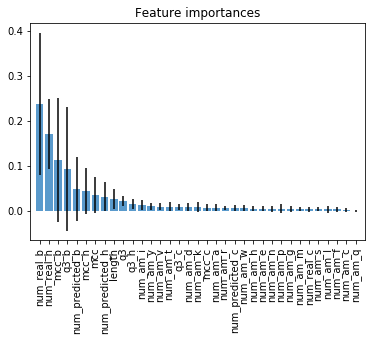

In [48]:
    # Feature importance plot of Random Forest;
    # see http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f):" % (f + 1, indices[f], importances[indices[f]]), x_train.columns[indices[f]])
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices],
           color="#5A9ACC", yerr=std[indices], align="center")
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation='vertical')
    plt.xlim([-1, x_train.shape[1]])
    plt.show()

From the feature importance plot, we can deduce a few important things:
first, it is clear how the information obtained through *real* data play an important role: all the most important features use information that are make use of data that wouldn't be accessible on unseen data, such as the number of real $\beta$-sheets.

We also see how the quantity of $\beta$-sheets (both real and predicted) has a huge impact in the classification of proteins.
The accuracy meaures are also pretty important, meaning the our model will prefer to assign a given classification based on the quality of the individual secondary structure predictions. This makes sense, as it means that when we have a low accuracy the model will be more likely to assign the most common overall secondary structure.

Also, the number of *Leucine (L)* and *Arginine (R)* is a useful predictor of the overall structure: as mentioned before, *leucine* is mostly encountered in $\alpha$-helices, and the output of the model confirms our theoretical knowledge.

***

Let's now see what happens if we use less information.

In [49]:
    # Use only features obtained though GOR III
    features = [1] + list(range(4, 7)) + list(range(10, 30))
    x_train = pred_data.iloc[:, features]
    y_train = pred_data.overall_structure_real

In [50]:
    clf = RandomForestClassifier(n_jobs = 2, criterion="entropy", bootstrap=False, min_samples_split=2, min_samples_leaf=2, max_depth=9, max_features=10) 
    
    param_grid = {
                     'n_estimators': [15, 100, 200, 300]
                 }
    
    grid_clf = GridSearchCV(clf, param_grid, cv=6, verbose=2, n_jobs=10)
    grid_clf.fit(x_train, y_train)
    
    print("\n-------- BEST ESTIMATOR --------\n")
    print(grid_clf.best_estimator_)
    print("\n-------- BEST PARAMS --------\n")
    print(grid_clf.best_params_)
    print("\n-------- BEST SCORE --------\n")
    print(grid_clf.best_score_)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


[Parallel(n_jobs=10)]: Done  18 out of  24 | elapsed:   17.1s remaining:    5.6s
[Parallel(n_jobs=10)]: Done  24 out of  24 | elapsed:   19.6s finished



-------- BEST ESTIMATOR --------

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=9, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

-------- BEST PARAMS --------

{'n_estimators': 100}

-------- BEST SCORE --------

0.728915662651


Using only the information obtained through **GOR III** gives a *cross-validation* accuracy of about 73%, which is significantly lower than the previous result. However, it can still be considered a good result, albeit worse than the previous.

In [51]:
    # Fit the overall model, using all data
    clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=9, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Feature ranking:
1. feature 2 (0.302273): num_predicted_b
2. feature 1 (0.148795): num_predicted_h
3. feature 0 (0.054355): length
4. feature 10 (0.051861): num_am_e
5. feature 14 (0.042145): num_am_l
6. feature 3 (0.031190): num_predicted_c
7. feature 22 (0.029927): num_am_y
8. feature 11 (0.029148): num_am_g
9. feature 23 (0.027129): num_am_v
10. feature 7 (0.026810): num_am_d
11. feature 6 (0.026384): num_am_n
12. feature 4 (0.026234): num_am_a
13. feature 15 (0.025555): num_am_k
14. feature 20 (0.024209): num_am_t
15. feature 13 (0.022382): num_am_i
16. feature 21 (0.018575): num_am_w
17. feature 9 (0.018329): num_am_q
18. feature 19 (0.017510): num_am_s
19. feature 18 (0.015226): num_am_p
20. feature 16 (0.014049): num_am_m
21. feature 5 (0.014003): num_am_r
22. feature 17 (0.013599): num_am_f
23. feature 8 (0.011713): num_am_c
24. feature 12 (0.008601): num_am_h


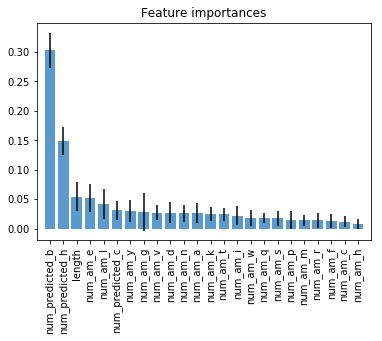

In [52]:
    # Feature importance plot of Random Forest;
    # see http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f):" % (f + 1, indices[f], importances[indices[f]]), x_train.columns[indices[f]])
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices],
           color="#5A9ACC", yerr=std[indices], align="center")
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation='vertical')
    plt.xlim([-1, x_train.shape[1]])
    plt.show()

Using a lower amount of features confirms the previous results: the number of $\beta$-sheets is still extremely important, and the quantity of *leucine* is also relevant. We can also notice how the length of the sequence is a good predictor, which indicates that longer sequences are more likely to obtain a certain overall structure.

We can now make the prediction over the entire dataset, and store the results. Clearly the prediction accuracy over the training set will be extremely high, but the *cross-validation* error is the value that should be kept into account as the *real* quality of the model.

In [53]:
    #%% Prediction
    pred_data.overall_pred = clf.predict(x_train)
    
    # Accuracy on the test set. It's very high, but it doesn't matter much.
    # What we want is to have a general method to classify, which we have, with accuracy > 80%
    print(sum(pred_data.overall_pred == pred_data.overall_structure_real) / pred_data.shape[0])
    # Which predictions were wrong?
    wrong_pred = pred_data.loc[pred_data.overall_pred != pred_data.overall_structure_real]
    
    #%% Save the predictions
    pred_data.to_csv("../data/pred_result_" + data_type + ".csv", index=False)

0.981927710843


*****

# <span style="color:#2E66A7">Part 6:</span> GOR V and multiple sequence alignment